Here I will calibrate the parameters given by the pictures provided

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import PIL.ExifTags
import PIL.Image
import pprint
%matplotlib inline

In [2]:
def plotter(image, title = '', imgSize = (18,9), grayScale = False, step = 100): #Funcion auxiliar para realizar los graficos
    plt.figure(figsize=imgSize)
    plt.title(title, fontsize = 16, fontweight = "bold")
    plt.imshow(image) if not grayScale else plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.yticks(np.arange(0, len(image), step))
    plt.xticks(np.arange(0, len(image[0]), step), rotation=90)
    plt.show() 

Ahora definimos el tamaño del tablero (la cantidad de puntos es igual a la cantidad de puntos en los que un cuadrado negro toca a uno blanco), y la lista de puntos a reconocer, tomando como origen (0, 0, 0) la esquina que se encuentra en las coordenadas (100, 100).

In [3]:
chessBoardSize  = (8, 6)
objp = np.zeros((np.prod(chessBoardSize), 3),  dtype=np.float32)
objp[:, :2] = np.mgrid[0:chessBoardSize[0], 0:chessBoardSize[1]].T.reshape(-1, 2)
objp = objp * 28

Cargamos imagenes y dibujamos

In [4]:
img_fnames = glob('./imagenes/img_cal_set1/*')
imgsGray = []
imgsColor = []
for imgName in img_fnames:
    img = cv.imread(imgName)
    imgsColor.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    imgsGray.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))


In [5]:
def findCorners(imgsColor, imgsGray, plot=True, maxCount = 30, epsilon = 0.001, flag=cv.CALIB_CB_ADAPTIVE_THRESH):
    imgPoints = []
    objPoints = []
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, maxCount, epsilon)
    cb_flags = flag 
    for imgColor, imgGray in zip(imgsColor, imgsGray):
        imgColor = imgColor.copy()
        ret, corners = cv.findChessboardCorners(imgGray, chessBoardSize, flags=cb_flags)
        if ret:
            objPoints.append(objp)
            corners_subp = cv.cornerSubPix(imgGray, corners, (5, 5), (-1, -1), criteria)
            imgPoints.append(corners_subp)
            cv.drawChessboardCorners(imgColor, chessBoardSize, corners_subp, ret)
            if plot:
                plotter(imgColor)
    return imgPoints, objPoints

def calibrateCamera(objPoints, imgPoints, widthAndHeight, returnMatrix=False):
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objPoints, imgPoints, widthAndHeight, None, None, flags = cv.CALIB_ZERO_TANGENT_DIST)
    dist[0][1] = 0
    dist[0][4] = 0
    print('Camera Matrix: \n{}'.format(mtx))
    print('\nDistortion Coefficients: \n{}\n'.format(dist))
    if returnMatrix:
        return mtx, dist

def getIntrinsecParams(imgsColor, imgsGray):
    imgPoints, objPoints = findCorners(imgsColor, imgsGray, False)
    height, width = imgsGray[0].shape
    return calibrateCamera(objPoints, imgPoints, (width,height), returnMatrix=True)

In [6]:
mtx, dist = getIntrinsecParams(imgsColor, imgsGray)
mtx1, dist1 = mtx, dist

Camera Matrix: 
[[812.39920107   0.         316.72937754]
 [  0.         812.72587741 247.34172601]
 [  0.           0.           1.        ]]

Distortion Coefficients: 
[[0.02524607 0.         0.         0.         0.        ]]



In [7]:
#Set 2
objp = np.zeros((np.prod(chessBoardSize), 3),  dtype=np.float32)
objp[:, :2] = np.mgrid[0:chessBoardSize[0], 0:chessBoardSize[1]].T.reshape(-1, 2)
objp = objp * 28
img_fnames = glob('./imagenes/img_cal_set2/*')
imgsGray = []
imgsColor = []
for imgName in img_fnames:
    img = cv.imread(imgName)
    imgsColor.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    imgsGray.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
mtx, dist = getIntrinsecParams(imgsColor, imgsGray)

Camera Matrix: 
[[660.98739219   0.         334.4723844 ]
 [  0.         663.73998528 229.39412035]
 [  0.           0.           1.        ]]

Distortion Coefficients: 
[[0.08694637 0.         0.         0.         0.        ]]



Se ve que se tiene que usar el set 1 en vez del set dos porque el fx y el fy del set 1 son mas similares entre si, lo que implica que es mejor. Fuente: Arial 12

In [29]:
#Levantamos la imagen para calibracion de parametros extrinsecos
objp = np.zeros((np.prod(chessBoardSize), 3),  dtype=np.float32)
objp[:, :2] = np.mgrid[0:chessBoardSize[0], 0:chessBoardSize[1]].T.reshape(-1, 2)
objp = objp * 28
img_fnames = glob('./imagenes/img_bloques/imgCalExtr.png')
imgsGray = []
imgsColor = []
for imgName in img_fnames:
    img = cv.imread(imgName)
    imgsColor.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    imgsGray.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
imgPoints, objPoints = findCorners(imgsColor, imgsGray, False)
mtx, dist = mtx1, dist1

In [32]:
ret, rvecs, t = cv.solvePnP(objPoints[0], imgPoints[0], mtx, dist, useExtrinsicGuess=False)
rotation = cv.Rodrigues(rvecs)[0]
print(t)
print(rotation)

[[-109.4894379 ]
 [-153.57046487]
 [ 703.24057018]]
[[ 0.99922502 -0.00776181  0.03858907]
 [ 0.00790023  0.99996289 -0.00343563]
 [-0.03856097  0.00373783  0.99924926]]


In [10]:
# lo que hizo el chabon
def squareDif(p1, p2):
    return np.sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)
def processImage(img, i):
    areas = []
    centers = []
    dims = []
    rots = []
    img = cv.medianBlur(img, 5)
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, img_bin = cv.threshold(imgGray, 30, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    kernel = np.ones((2,2), np.uint8)
    opening = cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel)
    
    kernel = np.ones((2,2), np.uint8)
    ending = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
    
    contours, hierarchy = cv.findContours(ending, cv.RETR_TREE, cv.CHAIN_APPROX_TC89_L1)
    
    for cnt in contours:
        rect = cv.minAreaRect(cnt)
        center = rect[0]
        dim = rect[1]
        rot = rect[2]
        area = cv.contourArea(cnt)
        if (dim[0] * dim[1] != 0) and (area / (dim[0] * dim[1]) > 0.95) and area > 7000:
            box = cv.boxPoints(rect)
            po1 = box[0]
            po2 = box[1]
            po3 = box[3]
            if (squareDif(po3, po1) < squareDif(po2, po1)):
                rot = rot -90
            rot = abs(rot)
            print("encontre bloque")
            cv.circle(img, (int(center[0]), int(center[1])), 10, (0,0,255), 2)
            box = np.int0(box)
            cv.drawContours(img, [box], 0, (0,0,255), 2)
            plt.figure(i)
            plt.imshow(img)
            plt.show()
            print(f"area for image: {area}, rot: {rot}, dim: {dim}, center at: {center}")
            areas.append(area)
            centers.append(center)
            dims.append(dim)
            rots.append(rot)
    return areas, centers, dims, rots
        
            

encontre bloque


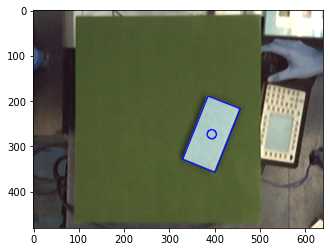

area for image: 11131.0, rot: 68.19859313964844, dim: (75.7636947631836, 150.0418243408203), center at: (394.0344543457031, 273.41375732421875)
encontre bloque


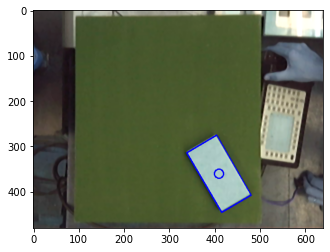

area for image: 11304.0, rot: 59.74356460571289, dim: (152.02508544921875, 76.01251983642578), center at: (410.53369140625, 360.7720031738281)
encontre bloque


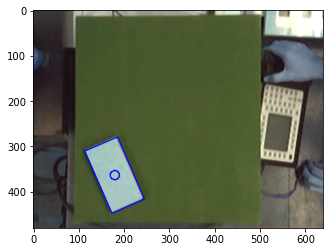

area for image: 11375.5, rot: 66.68228912353516, dim: (149.4651641845703, 78.24755096435547), center at: (180.4128875732422, 363.597900390625)
encontre bloque


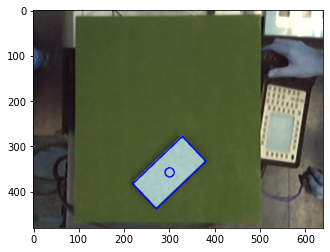

area for image: 11137.5, rot: 43.68308639526367, dim: (75.60794067382812, 150.10269165039062), center at: (301.0484619140625, 357.89190673828125)
encontre bloque


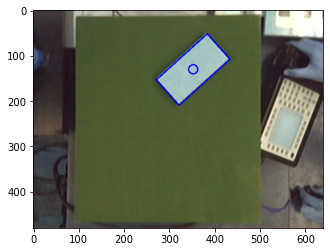

area for image: 11129.5, rot: 42.03176498413086, dim: (75.43860626220703, 150.36459350585938), center at: (353.49102783203125, 130.95877075195312)
encontre bloque


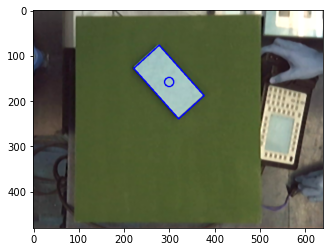

area for image: 11032.5, rot: 48.12213134765625, dim: (149.06796264648438, 75.22718811035156), center at: (300.1384582519531, 158.46209716796875)
encontre bloque


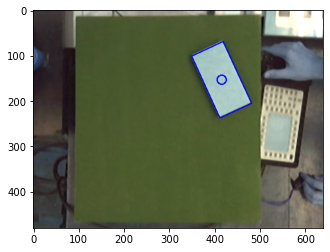

area for image: 11206.5, rot: 65.29756927490234, dim: (149.95542907714844, 76.53125), center at: (416.21771240234375, 153.4298553466797)
encontre bloque


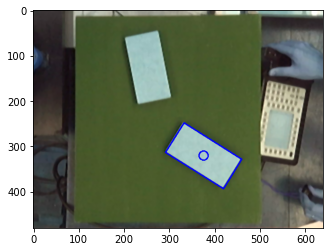

area for image: 11211.0, rot: 32.00538635253906, dim: (150.73171997070312, 76.3198471069336), center at: (376.82025146484375, 320.8876647949219)
encontre bloque


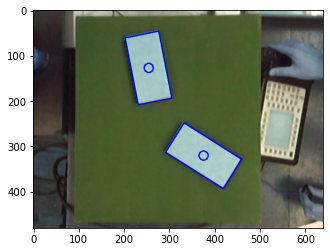

area for image: 11148.0, rot: 78.90628051757812, dim: (150.46812438964844, 75.33026123046875), center at: (255.31228637695312, 127.74268341064453)
encontre bloque


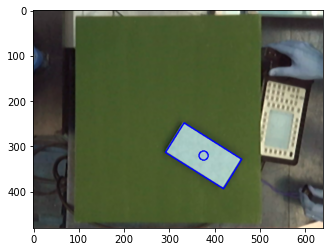

area for image: 11234.5, rot: 32.0053825378418, dim: (150.73167419433594, 76.31983947753906), center at: (376.8202209472656, 320.88763427734375)
encontre bloque


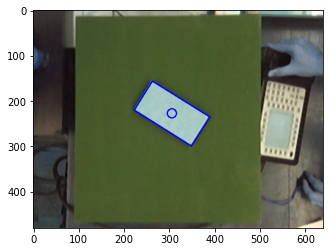

area for image: 11065.0, rot: 32.195735931396484, dim: (149.31309509277344, 75.6281509399414), center at: (306.78240966796875, 227.99264526367188)
encontre bloque


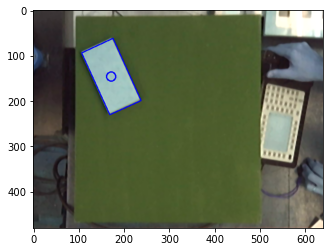

area for image: 11149.0, rot: 65.62352752685547, dim: (150.09153747558594, 75.98509216308594), center at: (172.67794799804688, 146.92718505859375)
encontre bloque


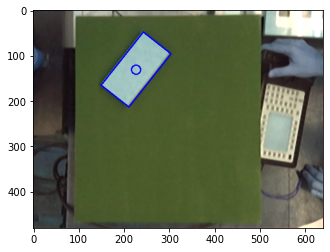

area for image: 11346.5, rot: 51.49934768676758, dim: (77.37078857421875, 149.01434326171875), center at: (227.46408081054688, 131.07369995117188)
encontre bloque


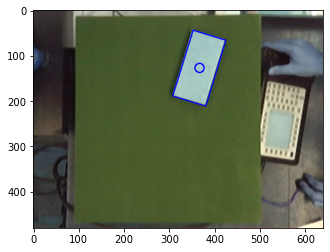

area for image: 11215.5, rot: 73.03385162353516, dim: (75.65897369384766, 151.77186584472656), center at: (367.16229248046875, 127.82916259765625)
encontre bloque


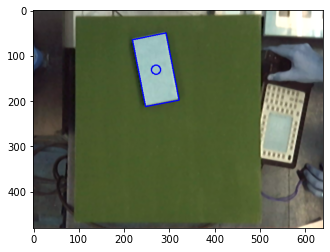

area for image: 11137.5, rot: 78.92979431152344, dim: (150.3024139404297, 75.28988647460938), center at: (271.3270568847656, 131.83819580078125)
encontre bloque


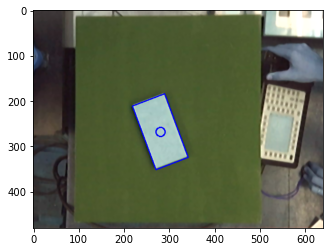

area for image: 11035.5, rot: 69.56716918945312, dim: (149.2349395751953, 75.49943542480469), center at: (281.311767578125, 268.0211181640625)
encontre bloque


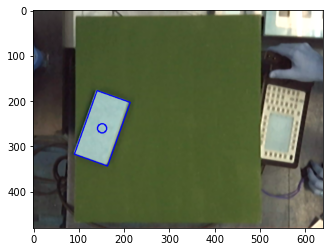

area for image: 11271.5, rot: 70.41600608825684, dim: (77.56439971923828, 148.94139099121094), center at: (152.64501953125, 260.4842834472656)


In [11]:
imgNames = glob('./imagenes/img_bloques/imgBloque*')
imgs = {}
for i in range(len(imgNames)):
    img = cv.imread(imgNames[i])
    imgs[i] = processImage(img, i)

In [12]:
#Flasheada mia
#pruebo con solo una imagen
img = cv.imread(imgNames[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgGray = cv.imread(imgNames[0], 0)
def createMask(img, samples, lowerMultiplier = 15, upperMultiplier = 6):
    meanColors = 0
    stdColors = 0
    for point1, point2, blockWidth in samples:
        colorMean, colorStd = cv.meanStdDev(img[point1[1]:point1[1] + blockWidth,point1[0]:point2[0], :])
        meanColors += colorMean
        stdColors += colorStd
    meanColors /= len(samples)
    stdColors /= len(samples)
    return cv.inRange(img, meanColors - stdColors * lowerMultiplier,  meanColors + stdColors * upperMultiplier)

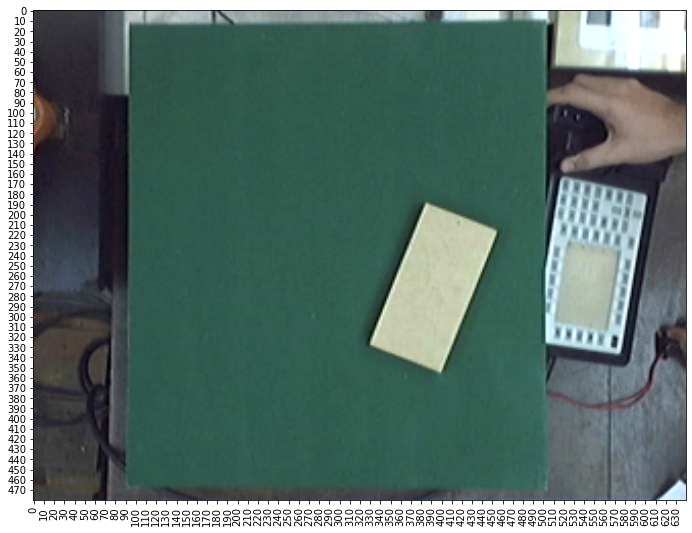

In [13]:
plotter(img, step=10)

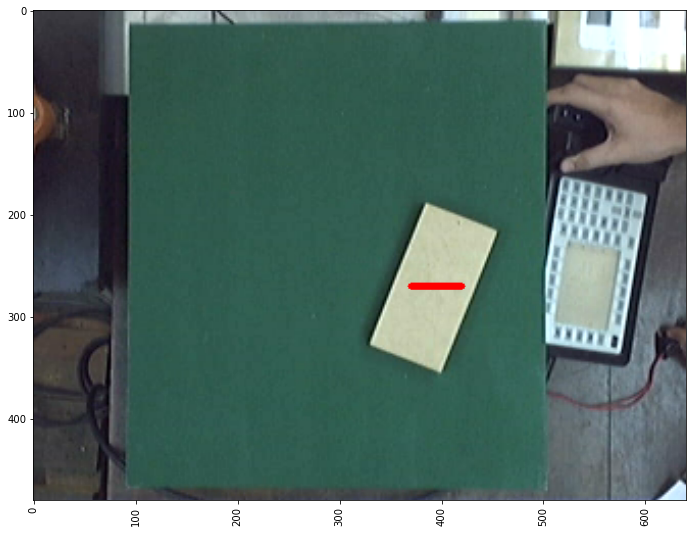

In [14]:
imgPrueba = img.copy()
block = ((370,270), (420, 270), 50)
cv.line(imgPrueba, block[0], block[1], (255,0,0), 5)

plotter(imgPrueba, step = 100)

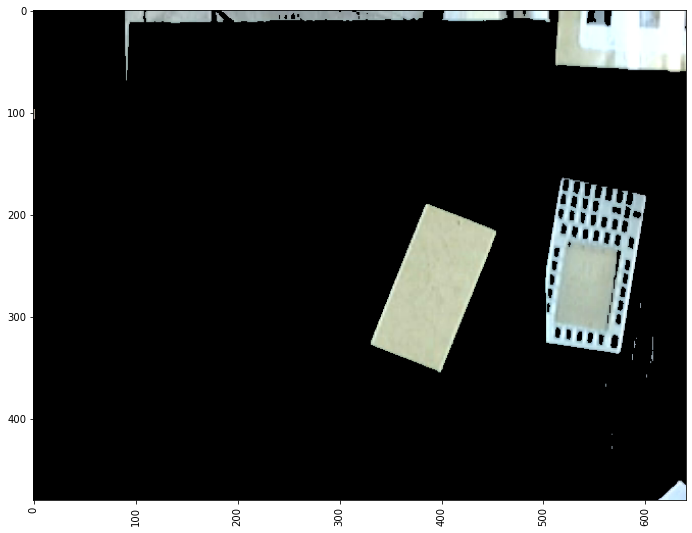

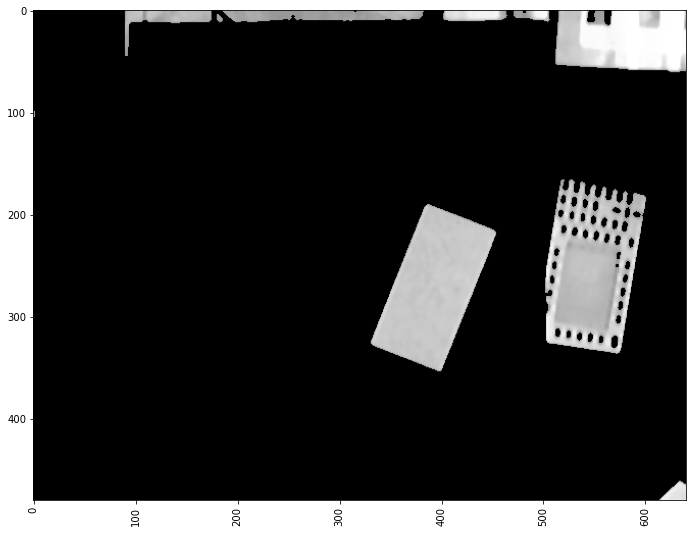

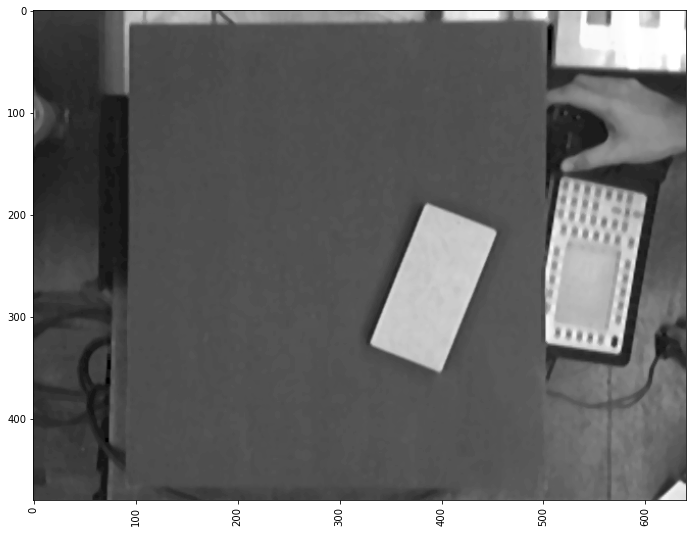

In [15]:
mask = createMask(img, [block], 3)
imgWithMask = cv.bitwise_and(img, img, mask=mask)
plotter(imgWithMask)
imgWithMaskGray = cv.cvtColor(imgWithMask, cv.COLOR_RGB2GRAY)
imgWithMaskGray = cv.medianBlur(imgWithMaskGray, 5)
plotter(imgWithMaskGray,grayScale=True)
imgGray = cv.medianBlur(imgGray, 5)
plotter(imgGray, grayScale=True)

In [16]:
IMGS = [imgGray, imgWithMaskGray] #Estas son las imagenes que vamos a analizar
NAMES = ['Original', 'With Mask']
def otsuBinarization(imgs, thresh = 127):
    result = []
    for imgNum, img in enumerate(imgs):
        ret, imgBin = cv.threshold(img,thresh,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        plotter(imgBin,NAMES[imgNum], grayScale=True)
        result.append(imgBin)
    return result

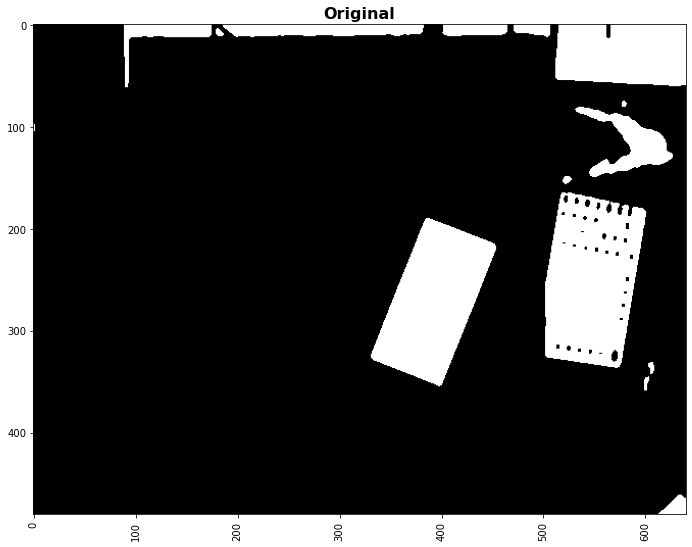

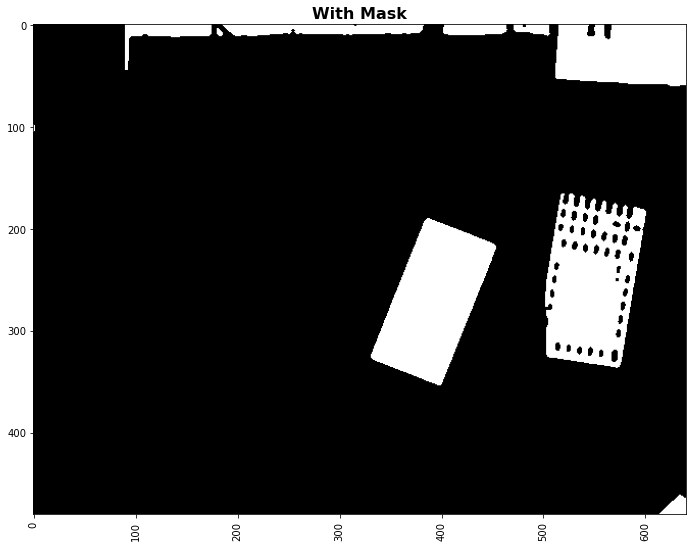

In [17]:
imgBin, imgMaskBin = otsuBinarization([imgGray, imgWithMaskGray])

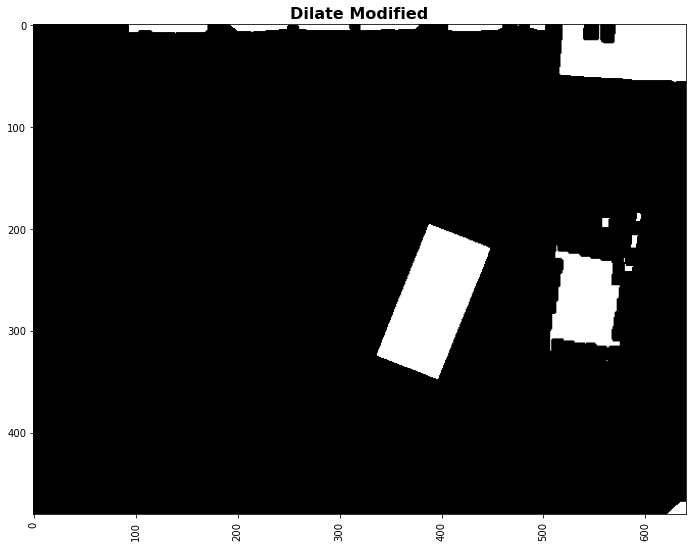

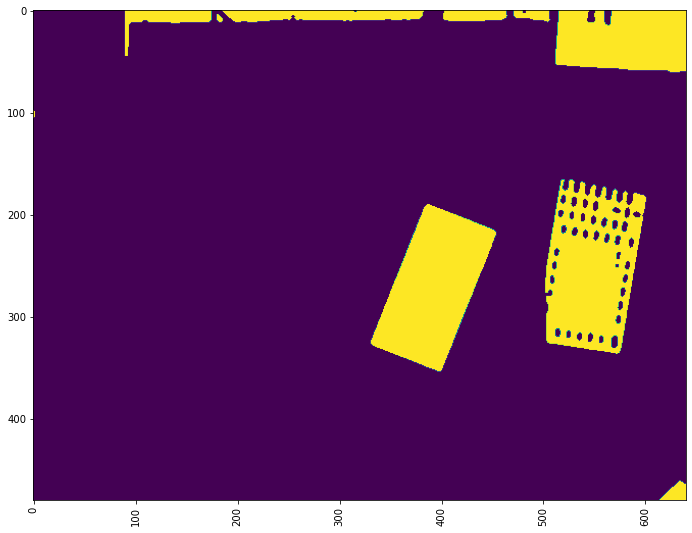

encontre bloque


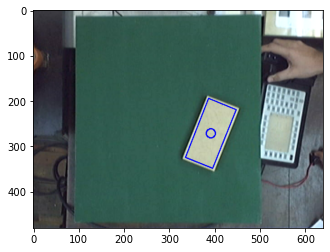

area for image: 8832.0, rot: 68.19858932495117, dim: (65.17906188964844, 139.08580017089844), center at: (392.0862121582031, 271.53448486328125)


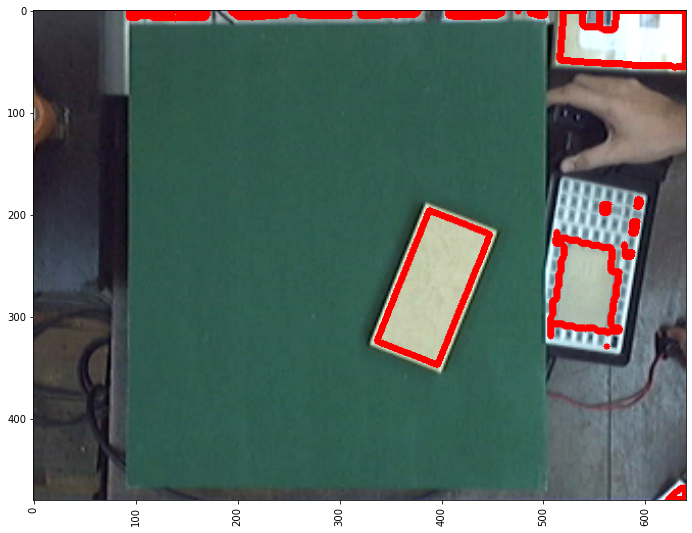

In [18]:
# TESTING
testing = imgMaskBin.copy()
#kernelErode = np.ones((10,1), np.uint8)
#testing = cv.erode(testing, kernelErode, iterations = 5)
kernelDilate = np.ones((5,5), np.uint8)
testing = cv.erode(testing, kernelDilate, iterations=2)
plotter(testing, 'Dilate Modified', grayScale=True)
plotter(imgMaskBin)
imgDilated = cv.erode(imgMaskBin.copy(), kernelDilate, iterations=2)
contours, hier = cv.findContours(imgDilated, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
realContours = []
out = img.copy()
for cnt in contours:
        rect = cv.minAreaRect(cnt)
        center = rect[0]
        dim = rect[1]
        rot = rect[2]
        area = cv.contourArea(cnt)
        if (dim[0] * dim[1] != 0) and (area / (dim[0] * dim[1]) > 0.95) and area > 7000:
            box = cv.boxPoints(rect)
            po1 = box[0]
            po2 = box[1]
            po3 = box[3]
            if (squareDif(po3, po1) < squareDif(po2, po1)):
                rot = rot -90
            rot = abs(rot)
            print("encontre bloque")
            cv.circle(img, (int(center[0]), int(center[1])), 10, (0,0,255), 2)
            box = np.int0(box)
            cv.drawContours(img, [box], 0, (0,0,255), 2)
            plt.figure(i)
            plt.imshow(img)
            plt.show()
            print(f"area for image: {area}, rot: {rot}, dim: {dim}, center at: {center}")
            realContours.append(cnt)
        
cv.drawContours(out, contours, -1, (255,0,0),5)
plotter(out)

In [19]:
def getAspectRatio(contour):
    x,y,width,height = cv.boundingRect(contour)
    return np.round(float(width) / height, 2)

def getCentroid(moment, area):
    try:
        return (int(moment['m10'] / area), int(moment['m01'] / area))
    except:
        return 0

def getOrientation(contour):
    (x, y), (MA, mA), angle = cv.fitEllipse(contour)
    return (int(x), int(y)), (int(MA), int(mA)), np.round(angle)

In [20]:
# Para mas info https://en.wikipedia.org/wiki/Image_moment
AREA = 0 #Para saber en que posicion del array que guarda el diccionario se encuentra la info deseada
PERIMETER = 1
CENTER = 2
ASPECT_RELATION = 3
ORIENTATION = 4
CONTOUR = 5

def getContoursInfo(contours):
    contoursArea = []
    contoursPerimeter = []
    contoursCenter = []

    for ctr in contours:
        moment = cv.moments(ctr)
        area = int(moment['m00'])
        contoursArea.append(area)
        contoursPerimeter.append(int(cv.arcLength(ctr,True)))
        contoursCenter.append(getCentroid(moment, area))

    contoursAreaMean = np.mean(contoursArea)

    contoursInfo = {}  
    contourNum = 1
    for area, perimeter, center, contour in  zip(contoursArea, contoursPerimeter, contoursCenter, contours):
        if area >= contoursAreaMean:
            contoursInfo[contourNum] = [area, perimeter, center, getAspectRatio(contour),
                                        getOrientation(contour), contour]
            contourNum += 1
            
    return contoursInfo

In [21]:
contoursInfo = getContoursInfo(realContours)

def printResults(contoursInfo):
    print('RESULTS')
    for key, value in contoursInfo.items():
        print('''
                Block Num: {}

                    Area: {}
                    Perimeter: {}
                    Centroid: {}
                    Aspect Relation: {}
                    Orientation: {}
                '''.format(key, value[AREA], value[PERIMETER], value[CENTER], value[ASPECT_RELATION],
                          value[ORIENTATION][2]))
    

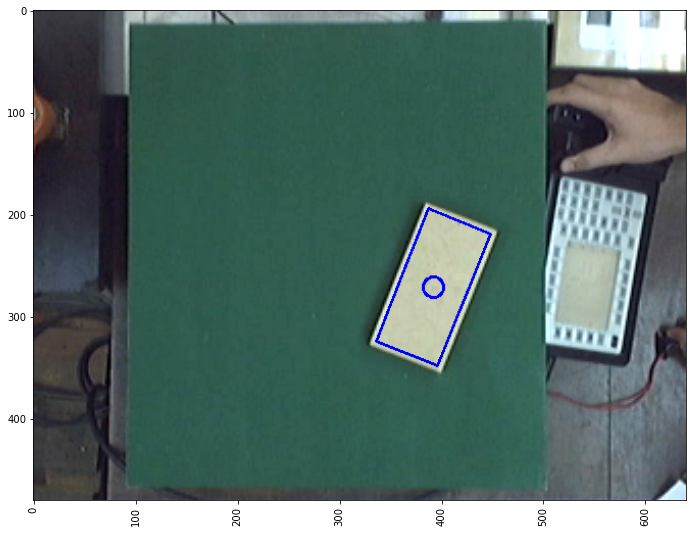

In [22]:
plotter(img)

In [23]:
printResults(contoursInfo)
centers = [x[CENTER] for x in contoursInfo.values()]

RESULTS

                Block Num: 1

                    Area: 8832
                    Perimeter: 435
                    Centroid: (392, 271)
                    Aspect Relation: 0.73
                    Orientation: 22.0
                


In [34]:
mtx, dist, rotation, t

(array([[812.39920107,   0.        , 316.72937754],
        [  0.        , 812.72587741, 247.34172601],
        [  0.        ,   0.        ,   1.        ]]),
 array([[0.02524607, 0.        , 0.        , 0.        , 0.        ]]),
 array([[ 0.99922502, -0.00776181,  0.03858907],
        [ 0.00790023,  0.99996289, -0.00343563],
        [-0.03856097,  0.00373783,  0.99924926]]),
 array([[-109.4894379 ],
        [-153.57046487],
        [ 703.24057018]]))

In [77]:
type(mtx)
c = np.append(np.asarray(centers[0]), 1)
c

array([392, 271,   1])

In [48]:
INDEP = np.asarray([[1, 0,0,0], [0,1,0,0], [0,0,1,0]])


In [97]:
a = []
for i in range(len(rotation)):
    a.append(np.append(rotation[i], t[i]))
a.append([0,0,0,1])
RT = np.asarray(a)

In [70]:
RT

array([[ 9.99225019e-01, -7.76181473e-03,  3.85890653e-02,
        -1.09489438e+02],
       [ 7.90022706e-03,  9.99962891e-01, -3.43563218e-03,
        -1.53570465e+02],
       [-3.85609666e-02,  3.73783201e-03,  9.99249258e-01,
         7.03240570e+02]])

In [110]:
def getCoord(center):
    # s * [uv1] = K * [R|T] *XwYwZw = k * (R XwYwZw + t)
    # ==> R^-1 * (K^-1 * [uv1] - t) = XwYwZw
    # K intrinsic params
    # R rotation
    # t translation
    # como s = R*XwYwZw[2] + t[2] para todo Zw, entonces => s =t[2]
    uv = np.array([[c[0],c[1],1]], dtype=np.float).T
    iK = np.linalg.inv(mtx)
    iR = np.linalg.inv(rotation)
    res_parcial_d = iR.dot(t)
    res_parcial_i = iR.dot(iK.dot(uv))
    print(res_parcial_d)
    print(res_parcial_i)
    s = res_parcial_d[2][0] / res_parcial_i[2][0]
    print(s)
    first = (s * iK.dot(uv) - t)
    return iR.dot(first)

In [111]:
getCoord(center)

[[-137.73546331]
 [-150.08633414]
 [ 699.01513481]]
[[0.05424946]
 [0.03212739]
 [1.00272461]]
697.1157647895402


/var/folders/hg/m61wgkzj28sdllsy9zrn7b280000gn/T/ipykernel_77934/2395313368.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uv = np.array([[c[0],c[1],1]], dtype=np.float).T


array([[ 1.75553620e+02],
       [ 1.72482841e+02],
       [-7.10542736e-14]])

In [102]:
mtx.dot(t)

array([[133787.81617498],
       [ 49130.04561967],
       [   703.24057018]])

In [112]:
centers

[(392, 271)]

In [114]:
#defino funcion de distorsion
def f_dist(x):
    #coeficiente de distorsion radial k1
    k1 = dist[0][0]
    #me interesa (u,v), la tercera posicion no
    xn = x[0:2]/x[2]
    #radio al cuadrado
    r_cuadrado = xn[0]**2+xn[1]**2
    xd = xn*(1+k1 * r_cuadrado)
    #xd hmogenea
    xd = np.vstack((xd,1))
    return xd;

#hallo inversa de matriz de camara
K_inversa = np.linalg.inv(mtx)

#defino Rt
Rt = np.hstack((rotation,t))
#hago z=0
Rt_z0 = np.delete(Rt,2,1)
#calculo su inversa
Rt_inv = np.linalg.inv(Rt_z0,)

#lista para almacenar los centros de los bloques en 3D(2D)
centros_en_mm = list()


#centros = (x_centro,Y_centro)
#calculo posicion para cada centro
for i in range(len(centers)):
    centro = centers[i]
    #creo (u,v,1)
    uv = np.matrix([[centro[0]],[centro[1]],[1]])
    #mutliplico a K**-1 por (u,v,1)
    x_dist = K_inversa.dot(uv)    
    #metodo iterativo
    iter = 0
    delta_x = x_dist - f_dist(x_dist)
    while(iter<3):
        X = x_dist - delta_x
        delta_x = x_dist - f_dist(X)
        iter +=1
    X_final = Rt_inv.dot(X)
    print(X_final)

[[0.25189534]
 [0.24744435]
 [0.00143449]]
